In [121]:
#Import Modules

#numpy
import numpy as np
from numpy.random import multivariate_normal #For later example

import pandas as pd

#advectionGP
from advectionGP.models import AdjointAdvectionDiffusionReactionModel as Model #Model module builds basic parts of the PDE problem, combines other classes into full model
from advectionGP.sensors import FixedSensorModel #Builds sensor arrays to generate data for foward model or to generate observations for comparison
from advectionGP.kernels import EQ #Generates exponentiated quadratic kernel approximation
from advectionGP.test import TestKernels #Unit test model
from advectionGP.wind import WindFixU #Wind model

#Plotting tools
from mpl_toolkits.mplot3d import Axes3D 
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter


# generate sensor locations for training data with shape [total observations, 4], where each row has elements 
#[lower time location, upper time location, x location, y location]

tlocL = np.linspace(6,8,6) # lower time
xloc=np.linspace(6,8,8) # x locations
yloc=np.linspace(6,8,8) # y locations
sensN = len(xloc)*len(yloc) # total number of sensors 
obsN = len(tlocL) # total time points at which an observation is taken
X= np.zeros((obsN*sensN,4)) # obsN*sensN is total observations over all sensors and all times
# Build sensor locations
X[:,0] = np.asarray(np.meshgrid(tlocL,xloc,yloc)).reshape(3,sensN*obsN)[0] #lower time
X[:,2] = np.asarray(np.meshgrid(tlocL,xloc,yloc)).reshape(3,sensN*obsN)[1] # x location
X[:,3] = np.asarray(np.meshgrid(tlocL,xloc,yloc)).reshape(3,sensN*obsN)[2] # ylocation
X[:,1] = X[:,0]+0.1 # upper time

sensors = FixedSensorModel(X,0.1) # establish sensor model arguments are sensor locations and spatial averaging

# generate sensor locations for test data with shape [total observations, 4], where each row has elements 
#[lower time location, upper time location, x location, y location]

tlocL = np.linspace(6,9,5) # lower time
xloc=np.linspace(6.5,7.5,4) # x locations
yloc=np.linspace(6.5,7.5,4) # y locations
sensN = len(xloc)*len(yloc) # total number of sensors 
obsN = len(tlocL) # total time points at which an observation is taken
Xtest= np.zeros((obsN*sensN,4)) # obsN*sensN is total observations over all sensors and all times
# Build sensor locations
Xtest[:,0] = np.asarray(np.meshgrid(tlocL,xloc,yloc)).reshape(3,sensN*obsN)[0] 
Xtest[:,2] = np.asarray(np.meshgrid(tlocL,xloc,yloc)).reshape(3,sensN*obsN)[1]
Xtest[:,3] = np.asarray(np.meshgrid(tlocL,xloc,yloc)).reshape(3,sensN*obsN)[2]
Xtest[:,1] = Xtest[:,0]+1

sensorsTest = FixedSensorModel(Xtest,1) # establish sensor model

In [122]:
X[1,:]

array([6.        , 6.1       , 6.        , 6.28571429])

In [413]:
# Run forward model to generate concentration
#u = [0.05,0.] #Advection


k_0 = 0.02 #Diffusion
R=0.1
noiseSD = 0.05 #Observation noise
N_feat=2000 # number of features used to approximate ground truth GP
boundary = ([5,5,5],[10,10,10])# corners of the grid - in units of space
k = EQ(0.2, 2.0) # generate EQ kernel arguments are lengthscale and variance
res = [200,60,60] # grid size for time, x and y
wind=np.cos(np.linspace(0,6*np.pi,res[1]))*0.05
u=[]
u.append(0*np.ones(res)*wind) #x direction wind
u.append(0*np.ones(res)*0.0) # y direction wind
windmodel=WindFixU(u) # establish fixed wind model
m = Model(resolution=res,boundary=boundary,N_feat=N_feat,noiseSD=noiseSD,kernel=k,sensormodel=sensors,windmodel=windmodel,k_0=k_0,R=R) #initiate PDE model to build concentration

dt,dx,dy,dx2,dy2,Nt,Nx,Ny = m.getGridStepSize() # useful numbers!

z=np.random.normal(0,1.0,N_feat) # Generate z to compute source
source=(m.computeSourceFromPhi(z))+5# Compute source
#source[source<0]=0

#source = np.zeros(m.resolution)
##source[0,int(Nx/2)-1,int(Ny/2)-1] = 10.0
#source[:,15:25,15:25] = 5
#source[:,2:7,2:7] = 25
#source[:,7:12,15:20] = 25
#source[:,18:28,10:20] = 25

concTrain=m.computeConcentration(source) # Compute concentration - runs advection diffusion forward model
yTrain= m.computeObservations() # Compute observations with noise uses m.sensormodel for observation locations
concTrainNN=m.computeConcentration(source,enforce_nonnegative=True) # Compute concentration - runs advection diffusion forward model
yTrainNN= m.computeObservations() # Compute observations with noise uses m.sensormodel for observation locations

m.sensormodel=sensorsTest
yTest= m.computeObservations()

print(np.min(concTrain))
print(np.min(yTest))

0.0
6.3608385755943235


In [414]:
N_feat = 10 #Number of features used to infer the source
k = EQ(2, 2.0) 
mInfer = Model(resolution=res,boundary=boundary,N_feat=N_feat,noiseSD=noiseSD,kernel=k,sensormodel=sensors,windmodel=windmodel,k_0=k_0,R=R) #Initiate new model for inference
#%timeit -n1 -r1 regress = mInfer.computeModelRegressors() # Compute regressor matrix

In [415]:
from time import time

In [416]:
"""
Computes the regressor matrix X, using getHs from the sensor model and getPhi from the kernel.
X here is used to infer the distribution of z (and hence the source).
X is [features x observations]
"""
dt,dx,dy,dx2,dy2,Nt,Nx,Ny = mInfer.getGridStepSize()
X = np.zeros([mInfer.N_feat,len(mInfer.sensormodel.obsLocs)])

adjs = []
st = time()
for j,H in enumerate(mInfer.sensormodel.getHs(mInfer)):
    pass
print("getHs (all)           %6.1fms" % (1e3*(time()-st)))

st = time()
mInfer.computeAdjoint(H)
print("computeAdjoint (once) %6.1fms" % (1e3*(time()-st)))


st = time()
#O(GN)
for j,H in enumerate(mInfer.sensormodel.getHs(mInfer)):
    adjs.append(mInfer.computeAdjoint(H))
print("getHs & comp.Adjoints %6.1fms" % (1e3*(time()-st)))

st = time()
for i,phi in enumerate(mInfer.kernel.getPhi(mInfer.coords)):
    pass
print("getPhis               %6.1fms" % (1e3*(time()-st)))

st = time()
#O(GNF)
for i,phi in enumerate(mInfer.kernel.getPhi(mInfer.coords)):
    for j,adj in enumerate(adjs):
        X[i,j] = np.sum((phi*adj))*dt*dx*dy
        
print("getPhis and products  %6.1fms" % (1e3*(time()-st)))
#phi * v, --> scale

getHs (all)            166.4ms
computeAdjoint (once)   54.4ms
getHs & comp.Adjoints 19649.4ms
getPhis                147.9ms
getPhis and products  6030.2ms


In [417]:
phis = np.array([p for p in mInfer.kernel.getPhi(mInfer.coords)])

In [418]:
def getphival(kernel,i,coords):
    c=1/(kernel.l2)
    norm = 1./np.sqrt(kernel.N_feat)
    return norm*np.sqrt(2*kernel.sigma2)*np.cos(c*(mInfer.kernel.W[i,:]@coords.T)+kernel.b[i])

In [441]:
scale = Nsamps / mInfer.sensormodel.spatialAveraging**2 / np.pi
newX= []
for obsi in range(len(mInfer.sensormodel.obsLocs)):
    locA = mInfer.sensormodel.obsLocs[obsi,[0,2,3]]
    locB = mInfer.sensormodel.obsLocs[obsi,[1,2,3]]

    Nsamps = 500
    
    particles = np.repeat(locA[None,:],Nsamps,0)
    particles[:,0]+=np.random.rand(len(particles))*(locB[0]-locA[0])
    #particles
    #approx_ad = np.zeros_like(ad)
    phiTimesAdj = np.zeros(len(phis))
    NewphiTimesAdj = np.zeros(len(phis))
    for nit in range(200):
        particles[:,1:]+=np.random.randn(len(particles),2)*dt*np.pi*2*np.sqrt(mInfer.k_0) #plus wind
        particles[:,0]-=dt
        gridp = mInfer.getGridCoord(particles)    
        keep = np.all((gridp>=0) & (gridp<np.array([Nt,Nx,Ny])),axis=1)
        #for gp in gridp[keep,:]:
        #    approx_ad[gp[0],gp[1],gp[2]]+=1
        for i in range(N_feat):
            NewphiTimesAdj[i] += np.sum(getphival(mInfer.kernel,i,particles[keep,:]))
        #for i,phi in enumerate(phis):        
        #    phiTimesAdj[i]+=np.sum(phi[gridp[keep,0],gridp[keep,1],gridp[keep,2]])
        if not np.any(keep): break
    newX.append(NewphiTimesAdj)
newX = np.array(newX)/scale

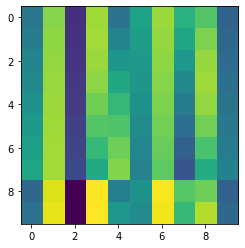

In [448]:
plt.imshow(newX[:10,:])

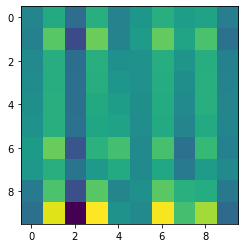

In [450]:
plt.imshow(X.T[:10,:])

In [437]:
print(X[:,1])

[-0.13207665  0.56705862 -0.62292856  0.63873101 -0.1104844   0.12413087
  0.61506791  0.20458711  0.50588019 -0.2791748 ]


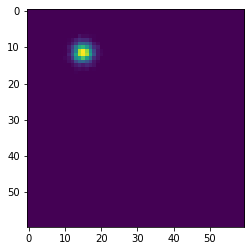

In [436]:
plt.imshow(approx_ad[1,:,:])

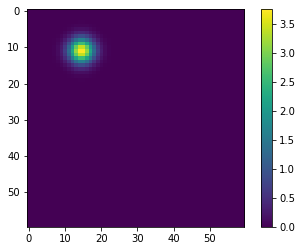

In [428]:
it = mInfer.sensormodel.getHs(mInfer)
next(it)
H = next(it)

ad = mInfer.computeAdjoint(H)
plt.imshow(ad[1,:,:])
plt.colorbar()

In [429]:
np.sum(approx_ad[1,:,:]),np.sum(ad[1,:,:])

(5000.0, 136.04721975014556)

500.0

```
Nfeat=1
getHs (all)              9.9ms O(N)
computeAdjoint (once)    9.7ms O(G)
getHs & comp.Adjoints 3360.4ms aGN+bN
getPhis                 84.3ms O(GF)
getPhis and products  2818.3ms cGNF+dGF
```

In [107]:
#1.63ns * GNF

Number of features, Number of observations

In [108]:
X.shape

(200, 384)

In [109]:
Nt*Nx*Ny

45000

So computeAdjoint takes 3.4s, the product still takes 2.8s

In [115]:
np.sum((phi*adj))*dt*dx*dy

-1.06266672825184

In [122]:
for it in range()
mInfer.k_0

0.01

In [ ]:
Parameters:
    boundary = a two element tuple of the corners of the grid. e.g. ([0,0,0],[10,10,10])        
    resolution = a list of the grid size in each dimension. e.g. [10,20,20]
    kernel = the kernel to use
    noiseSD = the noise standard deviation
    sensormodel = an instatiation of a SensorModel class that implements the getHs method.
    N_feat = number of fourier features
    spatial_averaging = how big the volume the sensor measures (default 0.001).
    u = wind speed
    k_0 = diffusion constant
    R = reaction constant

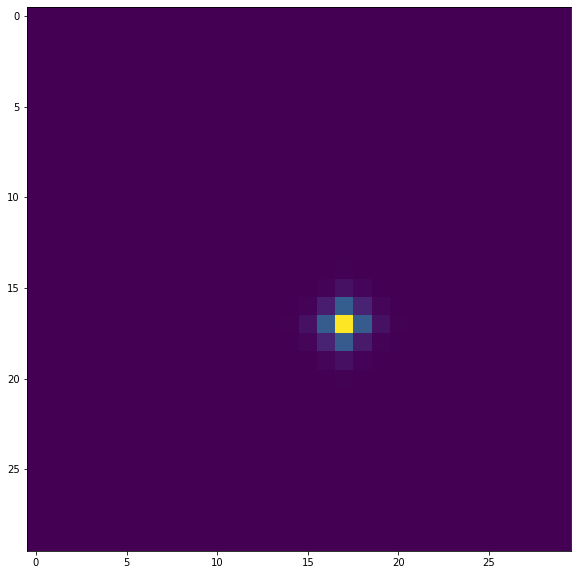

In [120]:
plt.figure(figsize=[10,10])
phi = next(mInfer.kernel.getPhi(mInfer.coords))
#plt.imshow(phi[25,:,:])
plt.imshow(adj[25,:,:])